In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

#Machine Learning
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

import torch
from torch import nn
import torchvision
import itertools
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from scipy.stats import mode

In [2]:
# Importar datos LANDSAT
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def concat_data(band_list):

    list_df = []

    #Recorremos bandas para agregar en df
    for band in band_list:
        for i in [8]:
            path = f'/content/drive/MyDrive/Cursos/Glaciares/{band}_LANDSAT{i}.nc'
            df = xr.open_dataset(path).to_dataframe()

            #Eliminamos columna
            df = df.drop(columns = ['spatial_ref'])

            if band == 'BOOL':
                df = df.rename(columns={"red": "bool"})

            list_df.append(df)

    #Concatenamos dfs
    return pd.concat(list_df, axis=1)

In [4]:
def crear_razones(green, NIR):
    return (green - NIR)/(green + NIR)

In [5]:
def get_images(data):

    imagenes_rect = []
    labels = []
    imagenes = data.index.get_level_values('time').unique()

    #Calculamos dimensiones de las imagenes
    ancho = len(data.index.get_level_values('x').unique())
    largo = len(data.index.get_level_values('y').unique())

    #Recorremos imagenes
    for img_name in imagenes:

        #Filtramos imagen
        filtered_data = data.loc[img_name]

        #Generamos imagen
        x = filtered_data.index.get_level_values('x')
        y = filtered_data.index.get_level_values('y')
        blue = filtered_data['blue'].values
        red = filtered_data['red'].values
        green = filtered_data['green'].values
        nir = filtered_data['nir08'].values
        glaciar = filtered_data['bool'].values

        #Calculamos razones
        NDWI = crear_razones(green, nir)

        img = np.column_stack((blue, red, green, nir, NDWI))

        #Redimensionamos la imagen
        img = img.reshape((5, largo, ancho))
        glaciar = glaciar.reshape(largo, ancho)

        #if resize_factor != 1:
        #    img = img[:, ::resize_factor, ::resize_factor]

        imagenes_rect.append(img)
        labels.append(glaciar)

    return np.array(imagenes_rect), np.array(labels)

In [6]:
def split_images(array, nrows, ncols):
    """Split a matrix into sub-matrices."""
    partes = np.split(array, nrows, axis=2)
    partes = [np.split(part, ncols, axis=3) for part in partes]

    #Unimos las imagenes en un solo array
    imagenes = np.concatenate([np.concatenate(part, axis=0) for part in partes])

    return imagenes

In [7]:
def split_labels(array, nrows, ncols):
    """Split a matrix into sub-matrices."""
    partes = np.split(array, nrows, axis=1)
    partes = [np.split(part, ncols, axis=2) for part in partes]

    #Unimos las imagenes en un solo array
    labels = np.concatenate([np.concatenate(part, axis=0) for part in partes])

    return labels

In [8]:
def resize_images(images, new_height, new_width):
    num_images, num_channels, old_height, old_width = images.shape

    # Crear un nuevo array para almacenar las imágenes redimensionadas con ceros agregados
    resized_images = np.zeros((num_images, num_channels, new_height, new_width), dtype=images.dtype)

    # Calcular el desplazamiento necesario para centrar las imágenes en la nueva forma
    vertical_offset = (new_height - old_height) // 2
    horizontal_offset = (new_width - old_width) // 2

    # Copiar las imágenes originales en la posición correcta del array redimensionado
    resized_images[:, :, vertical_offset:vertical_offset+old_height, horizontal_offset:horizontal_offset+old_width] = images

    return resized_images

In [9]:
def resize_labels(labels, new_height, new_width):
    num_labels, old_height, old_width = labels.shape

    # Crear un nuevo array para almacenar las imágenes redimensionadas con ceros agregados
    resized_images = np.zeros((num_labels, new_height, new_width), dtype=labels.dtype)

    # Calcular el desplazamiento necesario para centrar las imágenes en la nueva forma
    vertical_offset = (new_height - old_height) // 2
    horizontal_offset = (new_width - old_width) // 2

    # Copiar las imágenes originales en la posición correcta del array redimensionado
    resized_images[:, vertical_offset:vertical_offset+old_height, horizontal_offset:horizontal_offset+old_width] = labels

    return resized_images

In [10]:
def most_common(array):
    reshaped_array = array.reshape(-1, 6 * 4)
    most_common_values = mode(reshaped_array, axis=1)
    return most_common_values.mode.squeeze()

In [11]:
def generate_dataset(X, y):

    #Separamos en entrenamiento, validación y test
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=72)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=72)

    #Obtenemos tensores de la data
    X_train = torch.tensor(X_train)
    X_test = torch.tensor(X_test)
    X_val = torch.tensor(X_val)

    y_train = torch.tensor(y_train)
    y_test = torch.tensor(y_test)
    y_val = torch.tensor(y_val)

    # Crear dataset de pytorch
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

    return train_dataset, val_dataset, test_dataset

In [12]:
bands = ['BLUE', 'RED', 'GREEN', 'NIR', 'BOOL']

data = concat_data(bands)

imagenes, labels = get_images(data)

#Agregandamos imagenes
imagenes = resize_images(imagenes, 864, 576)
labels = resize_labels(labels, 864, 576)

imagenes_recortadas = split_images(imagenes, 144, 144)
labels_recortados = split_labels(labels, 144, 144)

labels = most_common(labels_recortados)

print('Dimensiones imagenes:', imagenes_recortadas.shape)
print('Dimensiones labels:', labels.shape)

train_ds, val_ds, test_ds = generate_dataset(imagenes_recortadas, labels)

Dimensiones imagenes: (1347840, 5, 6, 4)
Dimensiones labels: (1347840,)


# Generación red neuronal

In [13]:
class CNNModel(nn.Module):
    def __init__(
        self,
        dim_1_img,
        dim_2_img,
        input_features=5
    ):
        super().__init__()

        self.conv_blocks = nn.Sequential(
            # Bloque 1
            nn.Conv2d(input_features, 16, kernel_size=7, padding="same"),
            nn.ReLU(),

            # Bloque 2
            nn.Conv2d(16, 32, kernel_size=7, padding="same"),
            nn.ReLU(),

            # Bloque 3
            nn.Conv2d(32, 64, kernel_size=7, padding="same"),
            nn.ReLU(),

            # Bloque 4
            nn.Conv2d(64, 128, kernel_size=7, padding="same"),
            nn.ReLU(),

        )

        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(dim_1_img*dim_2_img*128, 3),
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)

In [14]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

In [15]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):

    # Predicción
    y_predicted = model(x_batch)

    y_batch = y_batch.long()

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)

        y_val = y_val.long()

        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(val_loader)

    return val_acc, val_loss


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    data_augmentation=False,
):

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(epochs):
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}', leave=False)
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    return curves

# Entrenamiento

In [20]:
model = CNNModel(6, 4)

epochs = 10
lr = 5e-4
batch_size = 64
criterion = nn.CrossEntropyLoss()


Epoch 1:   0%|          | 0/14742 [00:00<?, ?it/s]

Iteration 2457 - Batch 2457/14742 - Train loss: 0.9214819516468281, Train acc: 0.5494304312449145
Iteration 4914 - Batch 4914/14742 - Train loss: 0.8879926855784831, Train acc: 0.571528484231943
Iteration 7371 - Batch 7371/14742 - Train loss: 0.8696815193071356, Train acc: 0.5830825250949538
Iteration 9828 - Batch 9828/14742 - Train loss: 0.8573963109383761, Train acc: 0.5914386000610439
Iteration 12285 - Batch 12285/14742 - Train loss: 0.8478867998781798, Train acc: 0.5976200044766401
Val loss: 0.7963789105415344, Val acc: 0.6294070512820513




Epoch 2:   0%|          | 0/14742 [00:00<?, ?it/s]
                                                  

Iteration 17199 - Batch 2457/14742 - Train loss: 0.792702620110927, Train acc: 0.6319416192026037
Iteration 19656 - Batch 4914/14742 - Train loss: 0.7885635568554743, Train acc: 0.6338790691759919
Iteration 22113 - Batch 7371/14742 - Train loss: 0.786335974462771, Train acc: 0.6350803716766142
Iteration 24570 - Batch 9828/14742 - Train loss: 0.7847290506609362, Train acc: 0.6363233162071421
Iteration 27027 - Batch 12285/14742 - Train loss: 0.7826660026435489, Train acc: 0.6373552722611102
Val loss: 0.7673003673553467, Val acc: 0.6466791310541311



Epoch 3:   0%|          | 0/14742 [00:00<?, ?it/s]

                                                  

Iteration 31941 - Batch 2457/14742 - Train loss: 0.7586312115289411, Train acc: 0.6514251932465419
Iteration 34398 - Batch 4914/14742 - Train loss: 0.7566203895808479, Train acc: 0.6520027975584944
Iteration 36855 - Batch 7371/14742 - Train loss: 0.7555623665104336, Train acc: 0.6527506951980466
Iteration 39312 - Batch 9828/14742 - Train loss: 0.755012884958919, Train acc: 0.6529832002238275
Iteration 41769 - Batch 12285/14742 - Train loss: 0.753968558816205, Train acc: 0.6534533717239134
Val loss: 0.7528237104415894, Val acc: 0.6552805476416588




Epoch 4:   0%|          | 0/14742 [00:00<?, ?it/s]
                                                  

Iteration 46683 - Batch 2457/14742 - Train loss: 0.7316968569045537, Train acc: 0.6667005695687551
Iteration 49140 - Batch 4914/14742 - Train loss: 0.7323863991825166, Train acc: 0.6659556205493388
Iteration 51597 - Batch 7371/14742 - Train loss: 0.733124584610444, Train acc: 0.6658916338849702
Iteration 54054 - Batch 9828/14742 - Train loss: 0.7332209118270767, Train acc: 0.6660154262895513
Iteration 56511 - Batch 12285/14742 - Train loss: 0.733098110677403, Train acc: 0.6660515525801726
Val loss: 0.741742730140686, Val acc: 0.6612505935422602



Epoch 5:   0%|          | 0/14742 [00:00<?, ?it/s]

                                                  

Iteration 61425 - Batch 2457/14742 - Train loss: 0.7102487501426864, Train acc: 0.676852369812856
Iteration 63882 - Batch 4914/14742 - Train loss: 0.7134634965494472, Train acc: 0.6750635808748728
Iteration 66339 - Batch 7371/14742 - Train loss: 0.7132256425193516, Train acc: 0.675524789744981
Iteration 68796 - Batch 9828/14742 - Train loss: 0.7143230954262256, Train acc: 0.674710995523451
Iteration 71253 - Batch 12285/14742 - Train loss: 0.7146399852998789, Train acc: 0.6747123250040696
Val loss: 0.734946608543396, Val acc: 0.6650888334916113




Epoch 6:   0%|          | 0/14742 [00:00<?, ?it/s]
                                                  

Iteration 76167 - Batch 2457/14742 - Train loss: 0.7006953192057893, Train acc: 0.684092758340114
Iteration 78624 - Batch 4914/14742 - Train loss: 0.6980883468507144, Train acc: 0.6841429298067141
Iteration 81081 - Batch 7371/14742 - Train loss: 0.6982337770800647, Train acc: 0.6841596581660336
Iteration 83538 - Batch 9828/14742 - Train loss: 0.6992362664612812, Train acc: 0.6832889281717367
Iteration 85995 - Batch 12285/14742 - Train loss: 0.7002408441829892, Train acc: 0.683014457512616
Val loss: 0.7287994027137756, Val acc: 0.6698619025007914



Epoch 7:   0%|          | 0/14742 [00:00<?, ?it/s]

                                                  

Iteration 90909 - Batch 2457/14742 - Train loss: 0.676472528253366, Train acc: 0.69519172091131
Iteration 93366 - Batch 4914/14742 - Train loss: 0.6789760943104267, Train acc: 0.6935497202441505
Iteration 95823 - Batch 7371/14742 - Train loss: 0.6828156666010538, Train acc: 0.6921014480466631
Iteration 98280 - Batch 9828/14742 - Train loss: 0.6849137655333228, Train acc: 0.6906205488859497
Iteration 100737 - Batch 12285/14742 - Train loss: 0.6863215383267763, Train acc: 0.6897586684030604
Val loss: 0.7324417233467102, Val acc: 0.6684571858182969




Epoch 8:   0%|          | 0/14742 [00:00<?, ?it/s]
                                                  

Iteration 105651 - Batch 2457/14742 - Train loss: 0.6616806895922994, Train acc: 0.7033029902359642
Iteration 108108 - Batch 4914/14742 - Train loss: 0.6648764382301245, Train acc: 0.700559511698881
Iteration 110565 - Batch 7371/14742 - Train loss: 0.6676683034778159, Train acc: 0.6992145109875203
Iteration 113022 - Batch 9828/14742 - Train loss: 0.6706954788362426, Train acc: 0.6979203759283752
Iteration 115479 - Batch 12285/14742 - Train loss: 0.672442250112631, Train acc: 0.6970293932117858
Val loss: 0.735092282295227, Val acc: 0.6692287907565685



Epoch 9:   0%|          | 0/14742 [00:00<?, ?it/s]

                                                  

Iteration 120393 - Batch 2457/14742 - Train loss: 0.650590365766218, Train acc: 0.7094817941415785
Iteration 122850 - Batch 4914/14742 - Train loss: 0.6527966293168093, Train acc: 0.7075279755849441
Iteration 125307 - Batch 7371/14742 - Train loss: 0.6554746852173989, Train acc: 0.7057701437873033
Iteration 127764 - Batch 9828/14742 - Train loss: 0.6577036988002648, Train acc: 0.7049451877098383
Iteration 130221 - Batch 12285/14742 - Train loss: 0.6601632958041249, Train acc: 0.7035930123718053
Val loss: 0.7399675250053406, Val acc: 0.6706978078505856




Epoch 10:   0%|          | 0/14742 [00:00<?, ?it/s]
                                                  

Iteration 135135 - Batch 2457/14742 - Train loss: 0.6370926967377193, Train acc: 0.7152092656631408
Iteration 137592 - Batch 4914/14742 - Train loss: 0.6396931951674173, Train acc: 0.713317014242116
Iteration 140049 - Batch 7371/14742 - Train loss: 0.6415720128586159, Train acc: 0.7124550664677157
Iteration 142506 - Batch 9828/14742 - Train loss: 0.6442369790640692, Train acc: 0.7112069513683996
Iteration 144963 - Batch 12285/14742 - Train loss: 0.6470654830979385, Train acc: 0.7098323294807097


Val loss: 0.735844612121582, Val acc: 0.6693277144666033

Tiempo total de entrenamiento: 736.2054 [s]


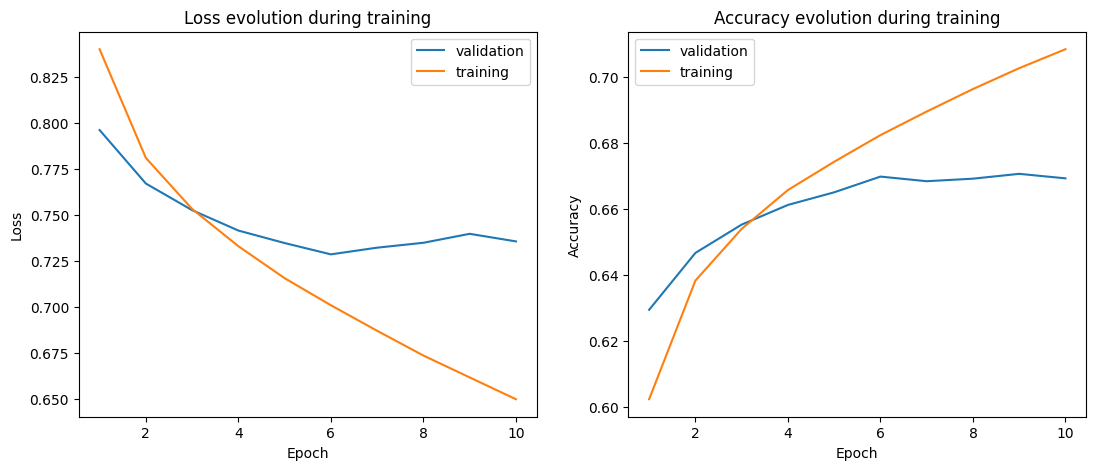

In [21]:
curves = train_model(
    model,
    train_ds,
    val_ds,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,
)

show_curves(curves)

In [22]:
torch.save(model.state_dict(), 'modelo_entrenado_3c.pth')

## Resultados

In [23]:
#Función para obtener las predicciones usando un modelo y una dataLoader
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  all_label = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat((all_preds, preds) ,dim=0)
    all_label = torch.cat((all_label, labels) ,dim=0)

  return all_preds, all_label

In [24]:
# Función  que plotea matriz de confusion
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=len(test_ds), shuffle=False, pin_memory=True)

pred_test, label_test = get_all_preds(model, test_loader)

Normalized confusion matrix
[[0.78180623 0.10667413 0.11151964]
 [0.18296399 0.72677721 0.0902588 ]
 [0.34526018 0.24775125 0.40698857]]


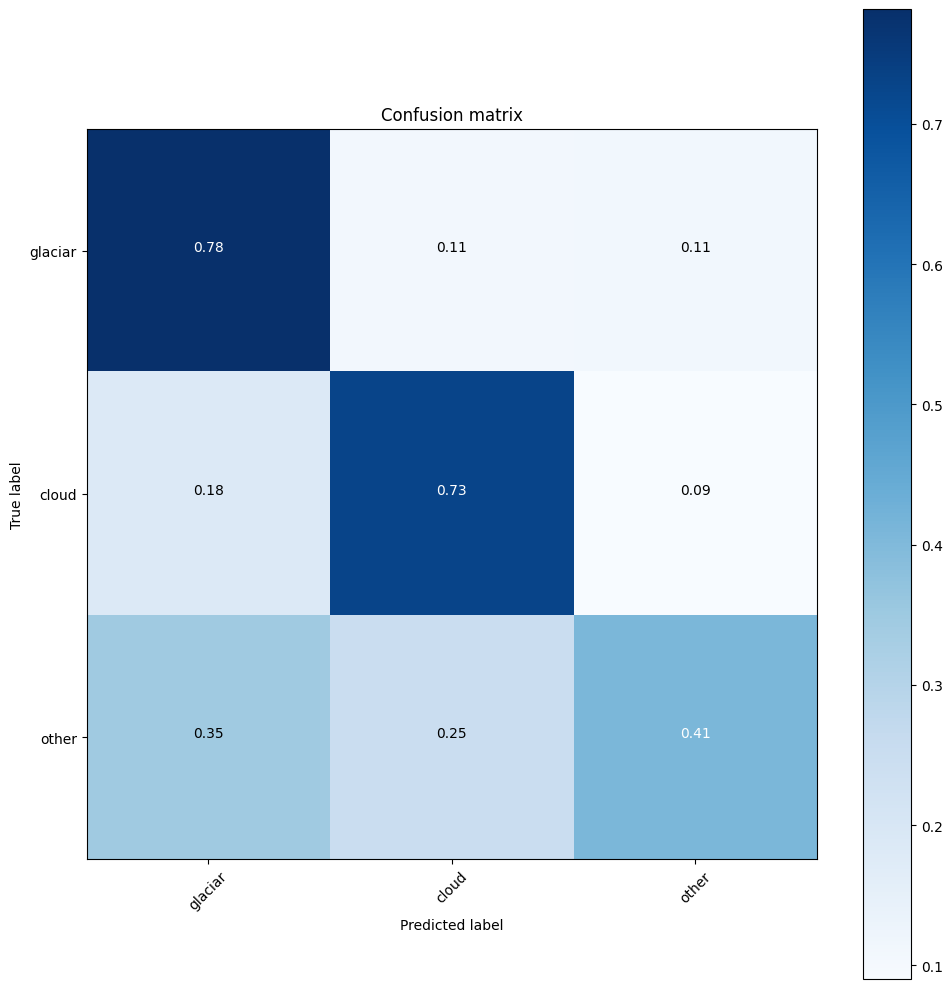

In [32]:
cm = confusion_matrix(label_test, pred_test.argmax(dim=1))
classes = ('glaciar', 'cloud', 'other')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)